# Imports

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Config

In [2]:
INPUT_PATH = 'ride_data/'
OUTPUT_PATH = 'data/pair_labels.parquet'
START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

# Loading Dataset

In [3]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path) 
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID', 'DOLocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [4]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)
print(f'rides_df shape : {rides_df.shape}')
rides_df.head()

rides_df shape : (12672629, 4)


,tpep_pickup_datetime,PULocationID,DOLocationID,PU_date
0,2023-01-01 00:32:10,161,141,2023-01-01
1,2023-01-01 00:55:08,43,237,2023-01-01
2,2023-01-01 00:25:04,48,238,2023-01-01
3,2023-01-01 00:03:48,138,7,2023-01-01
4,2023-01-01 00:10:29,107,79,2023-01-01


# Labeling

In [5]:
def labeling(dataset):
    dataset=rides_df
    dataset_labels = (
        dataset
        .groupby([dataset.PU_date.dt.date,(dataset.tpep_pickup_datetime.dt.hour//3)*3,'PULocationID', 'DOLocationID'])['PULocationID']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'DOLocationID','PU_date','tpep_pickup_datetime'])
        .reset_index()
        .rename(columns={'PULocationID': 'PULocation', 'DOLocationID': 'DOLocation', 'PU_date': 'Date', 'tpep_pickup_datetime': 'Hour_interval'})
    )
  
    pu_locations = pd.DataFrame(dataset_labels['PULocation'].unique(), columns=['PULocation'])
    do_locations = pd.DataFrame(dataset_labels['DOLocation'].unique(), columns=['DOLocation'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])
    hour = pd.DataFrame(dataset_labels['Hour_interval'].unique(), columns=['Hour_interval'])\
        .sort_values('Hour_interval').reset_index(drop=True)
    
    location_date_df = (
        pu_locations
        .merge(dates, how='cross')
        .merge(do_locations, how='cross')
        .sort_values(['PULocation', 'DOLocation', 'Date'], ascending=[True, True, True])
        .reset_index(drop=True)
    )
     
    location_date_hour_df = (
        location_date_df
        .merge(hour, how='cross')
        .sort_values(['PULocation', 'DOLocation', 'Date', 'Hour_interval'])
        .reset_index(drop=True)
    )
    
    labels_df = (
        location_date_hour_df
        .merge(dataset_labels, how='left', on=['PULocation', 'DOLocation', 'Date', 'Hour_interval'])
        .fillna(value=0)
    )
    
    labels_df['Date'] = pd.to_datetime(labels_df['Date'])

    return labels_df

In [6]:
labels_df = labeling(rides_df)
print(f'labels_df shape : {labels_df.shape}')
labels_df.head()

labels_df shape : (65646720, 5)


,PULocation,Date,DOLocation,Hour_interval,Demand
0,1,2023-01-01,1,0,0.0
1,1,2023-01-01,1,3,1.0
2,1,2023-01-01,1,6,1.0
3,1,2023-01-01,1,9,1.0
4,1,2023-01-01,1,12,12.0


In [7]:
mean_labeled_df = (labels_df.groupby(['PULocation', 'DOLocation'], as_index=False)['Demand']
                   .mean().sort_values('Demand', ascending=False)
                   .reset_index(drop=True))

In [8]:
def plot_cumsum_demand(labeled_df, target_demand):
    grouped_df = (labeled_df.groupby(['PULocation', 'DOLocation'], as_index=False)['Demand']
                  .sum().reset_index().sort_values(by='Demand', ascending=False).reset_index(drop=True))
    cumulative_demand = (grouped_df['Demand'].cumsum() / grouped_df['Demand'].sum()).to_numpy()
    
    plt.plot(range(0,len(cumulative_demand)), cumulative_demand)
    plt.xlabel('Location numbers')
    plt.ylabel('Cumulative Demand')
    plt.title('Cumulative Demand by Location')
    target_x = (cumulative_demand <= target_demand).argmin()
    plt.axhline(y=target_demand, color='r', linestyle='--', label=f'Target Demand ({target_demand})')
    plt.axvline(x=target_x, color='g', linestyle='--', label=f'Target Location ({target_x})')
    important_pairs = grouped_df.iloc[:target_x][['PULocation', 'DOLocation']]
    
    plt.legend() 
    plt.show()
    return target_x, important_pairs

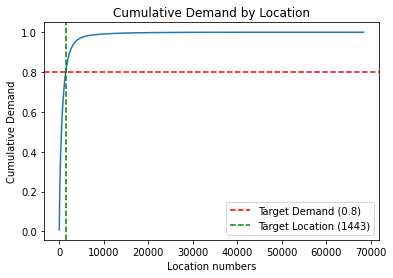

In [9]:
last_pair_index, important_pairs = plot_cumsum_demand(labels_df, 0.8)

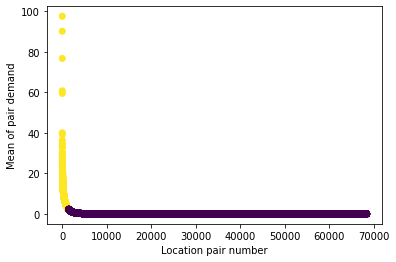

In [10]:
pair_labels = np.concatenate((np.ones(last_pair_index), np.zeros(len(mean_labeled_df) - last_pair_index)))
plt.scatter(range(len(mean_labeled_df['Demand'].values)), mean_labeled_df['Demand'].values, c = pair_labels)
plt.xlabel('Location pair number')
plt.ylabel('Mean of pair demand')
plt.show()

In [11]:
merged_df = pd.merge(labels_df, important_pairs, on=['PULocation', 'DOLocation'], how='inner')

In [12]:
print(f'labels_df shape : {merged_df.shape}')
merged_df.head()

labels_df shape : (1385280, 5)


,PULocation,Date,DOLocation,Hour_interval,Demand
0,13,2023-01-01,68,0,1.0
1,13,2023-01-01,68,3,1.0
2,13,2023-01-01,68,6,2.0
3,13,2023-01-01,68,9,3.0
4,13,2023-01-01,68,12,8.0


In [13]:
merged_df[merged_df['Demand'] == 0]['Hour_interval'].to_frame('Count').value_counts()

Count
3        104752
0         58021
6         33891
21        11467
9          9147
12         4471
18         3591
15         3015
Name: count, dtype: int64

# File saving

In [16]:
def save_labels(dataset, path):
    labels_df = dataset.to_parquet(path, index=False)

In [17]:
save_labels(merged_df, OUTPUT_PATH)